# Evaluating Production Models

In [238]:
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.tree import export_graphviz
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import  LogisticRegression
from sklearn.pipeline import Pipeline

from functions import top_words_subreddit
from IPython.display import Image
from graphviz import Source

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, f1_score, balanced_accuracy_score, 
                             RocCurveDisplay)

In [239]:
df = pd.read_csv('./data/stoicism_buddhism_clean.csv', lineterminator='\n')
df.head()

,title,selftext,subreddit,created_utc,name,upvote ratio,num_upvotes,combined_text,is_stoicism,contains_https,contains_emoji
0,Looking for Seneca's quote on why even bed fle...,I think it was Seneca who wrote something alon...,Stoicism,1.705696e+09,t3_19aswwj,0.67,1,Looking for Senecas quote on why even bed flea...,1,False,False
1,READ BEFORE POSTING: r/Stoicism beginner's gui...,"Welcome to the r/Stoicism subreddit, a forum f...",Stoicism,1.705694e+09,t3_19as7c7,0.76,2,READ BEFORE POSTING rStoicism beginners guide ...,1,True,False
2,The New Agora: Daily WWYD and light discussion...,"Welcome to the New Agora, a place for you and ...",Stoicism,1.705694e+09,t3_19as6qt,0.76,2,The New Agora Daily WWYD and light discussion ...,1,True,False
3,My biggest life mistake was wanting to live an...,"2023 summons this the best, I didn’t want to e...",Stoicism,1.705691e+09,t3_19aqv6w,0.94,27,My biggest life mistake was wanting to live an...,1,False,False
4,What’s your favorite way to practice gratitude...,You can mention some relevant quotes as well.,Stoicism,1.705691e+09,t3_19aqp1z,1.00,3,Whats your favorite way to practice gratitude ...,1,False,False


In [240]:
# define an evaluation function

def predict_evaluate(X_test, y_test, model):

    preds = model.predict(X_test)

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')

    plt.figure(figsize=(12,5))

    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    b_acc = balanced_accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)

    print(f'balanced_accuracy: {b_acc}')
    print(f'f1 score: {f1}')
    print(f'sensitivity (recall): {sensitivity}')
    print(f'specificity (precision): {specificity}')

    
    return preds

In [241]:
y = df['is_stoicism']
X = df['combined_text']

y.value_counts(normalize=True) # find baseline 
# baseline is 51% of posts are in the stoicism subreddit

is_stoicism
0    0.517519
1    0.482481
Name: proportion, dtype: float64

## Evaluating Logistic Regression Model

In [242]:
# evaluating production logreg model from 03_optimal_model.ipynb
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

logreg_best_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df = 0.5, max_features = 4000, 
                              ngram_range = (1, 1))),
    ('logreg', LogisticRegression(max_iter=10000, C = 0.97))
])

logreg_best = logreg_best_pipe.fit(X_train, y_train)

In [243]:
print('train score:', logreg_best.score(X_train, y_train))
print('test score:', logreg_best.score(X_test, y_test))

train score: 0.9623125493291239
test score: 0.9250788643533123


balanced_accuracy: 0.9240295711780647
f1 score: 0.9201009251471826
sensitivity (recall): 0.8937908496732027
specificity (precision): 0.9542682926829268


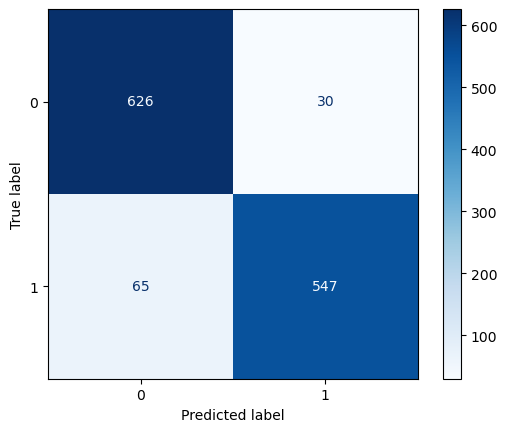

<Figure size 1200x500 with 0 Axes>

In [244]:
logreg_best_preds = predict_evaluate(X_test, y_test, logreg_best);

**Insights:**<br/>
- Balanced Accuracy: 0.92; F1 score 0.92. <br/>
- Specificity higher than sensitivity, meaning the model is better at classifying the buddhist subreddits (the negative class) correctly (95% of the time) and slightly worse at predicting the stoicism submissions (the positive class) correctly (89% of the time).<br/>
- High precision (specificity) means when the model predicts a submission is from r/stoicism, it's very likely to be correct.<br/>
- High recall (sensitivity) indicates the model is good at catching most of the r/stoicism submissions, though it might also include some from r/buddhism (false positives).<br/>
- The model is more adept at correctly classifying submissions that are from r/buddhism.<br/>
- More false negatives than false positives: most of the models errors are when it predicts a submission is in the buddhism class when in fact it is from the stocisim class.<br/>

In [245]:
# Create a data frame of coefficients

tfidf_vectorizer = logreg_best_pipe.named_steps['tfidf']
logreg_access = logreg_best_pipe.named_steps['logreg']

feature_names = tfidf_vectorizer.get_feature_names_out()
idf = tfidf_vectorizer.idf_
coef = logreg_access.coef_.flatten()

coefficients_df = pd.DataFrame({'Feature Name': feature_names, 'IDF Score': idf, 'Coefficent' : coef})

coefficients_df.sort_values('Coefficent', ascending=False).head(15)

,Feature Name,IDF Score,Coefficent
3373,stoicism,2.805865,9.206516
3371,stoic,2.816728,8.543131
3378,stoics,4.058628,4.129023
1216,epictetus,4.278625,4.111882
2177,marcus,3.810587,4.059558
310,aurelius,3.885452,3.489320
3142,seneca,4.718714,3.349736
780,control,3.670113,3.184361
2223,meditations,4.263041,2.722286
2165,man,3.885452,2.454993


In [246]:
coefficients_df.sort_values('Coefficent', ascending=True).head(15)

,Feature Name,IDF Score,Coefficent
481,buddhism,3.005869,-7.200463
483,buddhist,3.102794,-6.906719
478,buddha,3.344690,-5.991547
1964,karma,4.702585,-3.396250
2222,meditation,3.958745,-3.005583
484,buddhists,4.412905,-2.637770
3550,temple,4.876938,-2.408037
978,dharma,4.710617,-2.382481
2004,lama,5.174190,-2.144529
1201,enlightenment,4.694617,-2.091396


- As seen previously many of the most extreme (lowest and highest) coefficients (representing the log odds of a submission being from r/stoicism) are technical terms. Later in the project removal of these terms is explored. <br/>
- The IDF score gives use some idea of how common the terms were in the corpus. The higher the score the less frequent the term was (more unique) and therefore the higher weighting the TF-IDF algorithm gives to the word.<br/>

In [247]:
# isolate the errors in the model 
df_logreg = pd.concat([X_test, y_test], axis=1)
df_logreg['predicted_logreg'] = logreg_best_preds
df_logreg_errors = df_logreg[df_logreg['predicted_logreg'] != df_logreg['is_stoicism']]
df_logreg_errors

,combined_text,is_stoicism,predicted_logreg
1105,You can dance in the rain or sulk in the rain ...,1,0
3631,A Message of Compassion During Our Election Th...,0,1
1757,I like it when it rains because even if i dont...,1,0
1463,This reminded me of Stocisms attitude towards ...,1,0
2448,Louis CK teaching his daughter a lesson in Fai...,1,0
...,...,...,...
4762,How to move on and let go of a parent Hello ev...,0,1
3038,strive not to seem happy but to be happy and i...,1,0
5629,Mind altering substances and asceticism THC is...,0,1
2342,Aristotle Politics Full Unabridged Audiobook,1,0


In [248]:
df_logreg_errors['predicted_logreg'].value_counts()

predicted_logreg
0    65
1    30
Name: count, dtype: int64

In [249]:
top_words_error_posts = top_words_subreddit(df_logreg_errors, bysubreddit=False, stopwords='english')
top_words_error_posts.head(20)

like         59
life         41
people       37
im           35
just         30
suffering    29
feel         28
things       25
time         25
right        25
way          22
love         22
person       21
bad          21
know         21
really       20
good         20
happy        19
think        19
dont         18
dtype: int64

In [250]:
# check post categorisation containing certain words to look for systematic pattern in errors 
df_logreg_errors[df_logreg_errors['combined_text'].str.contains('suffering')]

,combined_text,is_stoicism,predicted_logreg
2437,Gods Love Meaningful Suffering The two main p...,1,0
1239,Buddhism and Stoicism both strive for tranquil...,1,0
6307,How does one live a good life Does life have a...,0,1
5868,Rock Bottom I came to Pattaya which is the wor...,0,1
4420,So many people in this sub are so concerned ab...,0,1
4762,How to move on and let go of a parent Hello ev...,0,1


In [251]:
# check post categorisation containing certain words to look for systematic pattern in errors 
df_logreg_errors[df_logreg_errors['combined_text'].str.contains('people')]

,combined_text,is_stoicism,predicted_logreg
3631,A Message of Compassion During Our Election Th...,0,1
5996,I get CARRIED away by my DESIRES easily and me...,0,1
5871,Banned from rBuddhism for quoting one of the m...,0,1
4500,Practicing Metta through Writing Exercises I h...,0,1
6211,Precognition and emphaty HelloI really need so...,0,1
5158,Giving Homeless People Money Im curious to kno...,0,1
1239,Buddhism and Stoicism both strive for tranquil...,1,0
5196,I need honest opinions about my pregnancy loss...,0,1
4274,Am I thinking right Like for example Im comfor...,0,1
6170,Why do people with a lot of money fame and pow...,0,1


Difficult to find any systematic issues with errors in modelling test data apart from the aformentioned regarding the word 'people'. 

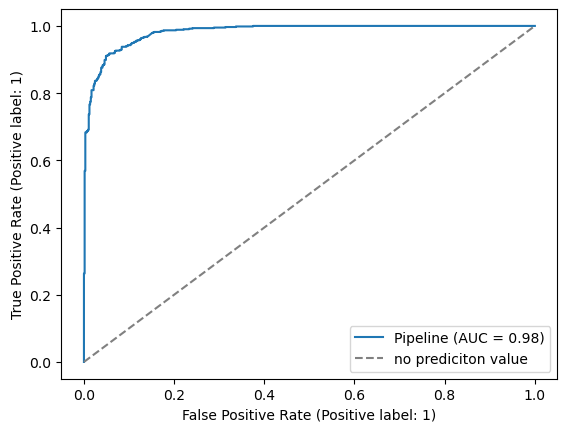

In [252]:
# plot ROC curve 
RocCurveDisplay.from_estimator(logreg_best, X_test, y_test)

plt.plot([0,1], [0,1], label = "no prediciton value", linestyle = '--', color='grey')

plt.legend();

A visualisation of positive class classification - (AUC) value is 0.98, which is very close to 1.0. This indicates an excellent level of separability, so the model can distinguish between the positive class (submissions from the r/stoicism subreddit) and the negative class (submissions from the r/buddhism subreddit) with high confidence.

# Restrictive Modelling
#### Removing Technical Jargon

Removal of technical jargon defined as: philosophers names; names of philosophical writings; words in Greek, Latin, Pali or Sanskrit; concepts highly specific to one philosophy (). The list was made by observing previously seen to be extreme (highest/lowest) coefficients in 03_optimal_model.ipynb and above. Researching additonal philosophers names, books, writings and specific terminology/phases based on domain knowledge. Several iterations were done, and coefficients observed, to come to the final list and remove as many high coefficient technical terms as possible.

In [253]:
# source for adding more stopwords to nltk default https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist


custom_stopwords_technical_jargon = ['stoicism', 'stoic', 'stoics', 'rstoicism', 'epictetus', 'seneca', 'marcus', 'aurelius', 
                     'mori', 'memento', 'ryan', 'holiday', 'senecas', 'buddhism', 'buddha', 'buddhist', 
                     'buddhists', 'buddhas', 'karma', 'lama', 'ajahn', 'rinpoche', 'bodhisattva', 'guanyin', 'meditation'
                     'rbuddhism', 'dhamma', 'altar', 'dalai', 'dharma', 'epictetus', 'hanh', 'mala', 'nhat', 'meditations',
                     'nirvana', 'sangha', 'sutra', 'zen', 'zeno', 'chrysippus', 'musonius', 'cleanthes', 'discourses', 
                     'enchiridion', 'eudaimonia', 'logos', 'amor', 'fati', 'apatheia', 'prohairesis', 'cosmos', 'cynicism', 
                     'dalai', 'thich', 'nhat', 'hanh', 'pali', 'canon', 'tripitaka', 'dhammapada', 'mahayana', 'theravada', 
                     'vajrayana', 'tibetan', 'anatta', 'anicca', 'dukkha', 'samsara', 'nirvana', 'vipassana', 'zazen', 'samatha', 
                     'metta', 'bodhi', 'bodhisattva', 'dharma', 'skandha', 'prajna', 'sunyata', 'tathagata', 'koan', 'mantra', 
                     'mudra', 'tanha', 'vinaya', 'dana', 'sila', 'bhikkhu', 'bhikkhuni', 'stupa', 'pagoda', 'sutra', 'tantra', 
                     'mandala', 'lamasery', 'karmapa', 'avalokiteshvara', 'manjushri', 'mahakala', 'green tara', 'white tara', 
                     'amitabha', 'maitreya', 'asanga', 'nagarjuna', 'vasubandhu', 'atisha', 'milarepa', 'tsongkhapa', 
                     'shantideva', 'ashoka', 'vimalakirti', 'padmasambhavastoicism', 'rstoicism', 'zeno', 'chrysippus', 
                     'musonius', 'cleanthes', 'discourses', 'enchiridion', 'eudaimonia', 'logos', 'amor', 'fati', 'apatheia', 
                     'prohairesis', 'cosmos', 'cynicism', 'dalai', 'thich', 'nhat', 'hanh', 'pali', 'canon', 'tripitaka', 
                     'dhammapada', 'mahayana', 'theravada', 'vajrayana', 'tibetan', 'anatta', 'anicca', 'dukkha', 'samsara', 
                     'nirvana', 'vipassana', 'zazen', 'samatha', 'metta', 'bodhi', 'bodhisattva', 'dharma', 'skandha', 'prajna', 
                     'sunyata', 'tathagata', 'koan', 'mantra', 'mudra', 'tanha', 'vinaya', 'dana', 'sila', 'bhikkhu', 'bhikkhuni', 
                     'stupa', 'pagoda', 'sutra', 'tantra', 'mandala', 'lamasery', 'karmapa', 'avalokiteshvara', 'manjushri', 
                     'mahakala', 'tara', 'amitabha', 'maitreya', 'asanga', 'nagarjuna', 'vasubandhu', 'atisha', 
                     'milarepa', 'tsongkhapa', 'shantideva', 'ashoka', 'vimalakirti', 'padmasambhava', 'mindfulness', 'samadhi', 
                     'bhavana', 'abhidhamma', 'tantra', 'yoga', 'koan', 'satori', 'kensho', 'zendo', 'sangharakshita', 'triratna', 
                     'mahamudra', 'dzogchen', 'shunyata', 'roshi', 'lamrim', 'tonglen', 'lojong', 'gelug', 'kagyu', 'nyingma', 
                     'sakya', 'hinayana', 'sutta', 'jataka', 'abhidharma', 'therigatha', 'theragatha', 'vajrayogini', 'tara', 
                     'marpa', 'milarepa', 'gampopa', 'sarvastivada', 'vaibhashika', 'sautrantika', 'yogacara', 'madhyamaka', 
                     'pratityasamutpada', 'skandhas', 'noble' ,'eightfold', 'brahmavihara', 'pancha' 
                     'paramita', 'bhikkhu', 'bhikkhuni', 'arhat', 'bodhisattva', 'mahasiddha', 'lama', 'rinpoche', 'khenpo', 
                     'geshe', 'dukkha', 'anatta', 'anicca', 'metta', 'karuna', 'mudita', 'upekkha', 'paticca samuppada','rome',
                     'sutras', 'namo', 'gautama', 'rbuddhism', 'meditate', 'meditates', 'monks', 'monk', 'meditation','meditating',
                     'thanissaro'
                    ]


In [254]:
# define stop word testing function 

def stop_word_eval(list_sw):

    list_sw = [word.lower() for word in list_sw]

    all_stopwords = list(ENGLISH_STOP_WORDS) + list_sw
    print('Additonal stop words:',len(list_sw))
    print('Default stop words:',len(list(ENGLISH_STOP_WORDS)))
    print('Total stop words:',len(all_stopwords))

    logreg_csw_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=all_stopwords, min_df=1, max_df = 0.5, max_features = 4000, 
                                ngram_range = (1, 1))),
        ('logreg', LogisticRegression(max_iter=10000, C = 0.97, random_state=42))
    ])

    logreg_csw = logreg_csw_pipe.fit(X_train, y_train)

    print('train score:', logreg_csw.score(X_train, y_train))
    print('test score:', logreg_csw.score(X_test, y_test))
    logreg_csw_preds = predict_evaluate(X_test, y_test, logreg_csw)

    return logreg_csw_pipe

Additonal stop words: 262
Default stop words: 318
Total stop words: 580


/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['green', 'paticca', 'samuppada', 'white'] not in stop_words.
  warnings.warn(


train score: 0.89344909234412
test score: 0.8138801261829653
balanced_accuracy: 0.812011796588554
f1 score: 0.7972508591065292
sensitivity (recall): 0.7581699346405228
specificity (precision): 0.8658536585365854


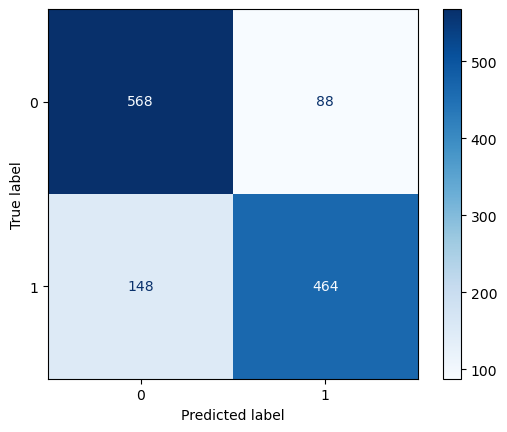

<Figure size 1200x500 with 0 Axes>

In [255]:
sw_tj_pipe = stop_word_eval(custom_stopwords_technical_jargon)

**Standard Stop Words:**<br/>
train score: 0.9623125493291239<br/>
test score: 0.9250788643533123<br/>
balanced_accuracy: 0.9240295711780647<br/>
f1 score: 0.9201009251471826<br/>
sensitivity (recall): 0.8937908496732027<br/>
specificity (precision): 0.9542682926829268<br/>

**Removal of Technical Jargon:**<br/>
train score: 0.8950276243093923<br/>
test score: 0.8138801261829653<br/>
balanced_accuracy: 0.8120665949306551<br/>
f1 score: 0.7975986277873071<br/>
sensitivity (recall): 0.7598039215686274<br/>
specificity (precision): 0.864329268292683<br/>

**Insights:**<br/>
- Test accuracy and balance accuracy fell around 10% with the removal of technical Jargon. <br/>
- False negatives (r/stoicism post classified incorrectly as r/buddhism) went from 65 to 148, a 126% increase.<br/>
- False positives (r/buddhism post classified incorrectly as r/stoicism)  30 to 88, a 127% increase. <br/>
- Suggests that the model relied fairly equally on technical Jargon to classify submissions between the two subreddits.  <br/>
- The model is still quite accurate - 30% above the based line - with the technical jargon removed. <br/>

In [256]:
# explore largest coefficients - those most predictive of r/Stoisism
tfidf_vectorizer = sw_tj_pipe.named_steps['tfidf']
logreg_access = sw_tj_pipe.named_steps['logreg']

feature_names = tfidf_vectorizer.get_feature_names_out()
idf = tfidf_vectorizer.idf_
coef = logreg_access.coef_.flatten()

coefficients_df_sw = pd.DataFrame({'Feature Name': feature_names, 'IDF Score': idf, 'Coefficent' : coef})

coefficients_df_sw.sort_values('Coefficent', ascending=False).head(50)

,Feature Name,IDF Score,Coefficent
787,control,3.670113,4.040324
2601,philosophy,3.906881,3.874475
2190,man,3.885452,3.065235
3825,virtue,4.735108,2.904143
2820,quote,4.507018,2.848437
2822,quotes,5.254233,2.129325
1173,emotions,4.395100,2.095628
2123,live,3.664431,1.716734
2077,letters,5.724236,1.702488
1366,fate,5.523566,1.697985


In [257]:
# explore smallest coefficients - those least predictive of r/Stoicism
coefficients_df_sw.sort_values('Coefficent', ascending=True).head(50)

,Feature Name,IDF Score,Coefficent
3552,temple,4.876938,-3.049991
2876,rebirth,4.956188,-2.950627
3535,teachings,4.193361,-2.902493
1210,enlightenment,4.694617,-2.885218
2690,practice,3.562191,-2.588885
700,compassion,4.794700,-2.468782
2323,monastery,5.746709,-2.216738
3374,statue,5.187093,-2.191930
2554,path,4.160261,-2.056531
3461,suffering,3.888992,-1.974149


Despite having very similar foundational ideas, being translated english many times over and being re-intrepretted over centuries the philosophies appear to have remarkably distinct vocabularies:<br/>
- Where stoics talk of virtues and being virtuous, buddhist talk of enlightenment <br/>
- The stoics speak of care and the buddhists of compassion<br/>
- There are more verbs in the stoicism subreddit top 50 coefficients: control, live, react, work, gonna, respond, act, deal, think, going, handle, stop, advice<br/>
- Compared to buddhism subreddit: thank, practice, suffering, teaching, painting, killing<br/>
- There are more suggesitons of mental states amd emotions in the buddhism top 50 coefficients: suffering, peace, compassion, emptiness, mindful, enlightenment, enlightened, beautiful
- Compared to stoicism subreddit: emotions, emotionally, emotion, react, strength  <br/>

Below we attempt to see if removing words related or rationality or words related to emotions affects the models ability to classify. <br/>

#### Removing Words Related to Rationality

Additonal stop words: 185
Default stop words: 318
Total stop words: 503


/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['occam', 'razor'] not in stop_words.
  warnings.warn(


train score: 0.9621152328334649
test score: 0.9250788643533123
balanced_accuracy: 0.9239747728359637
f1 score: 0.919966301600674
sensitivity (recall): 0.8921568627450981
specificity (precision): 0.9557926829268293


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, max_features=4000,
                                 stop_words=['most', 'this', 'are', 'becoming',
                                             'must', 'take', 'last', 'were',
                                             'done', 'move', 'would', 'still',
                                             'five', 'nothing', 'thereby',
                                             'she', 'i', 'here', 'during',
                                             'meanwhile', 'wherever', 'indeed',
                                             'hundred', 'third', 'rather',
                                             'nobody', 'hasnt', 'several',
                                             'above', 'beside', ...])),
                ('logreg',
                 LogisticRegression(C=0.97, max_iter=10000, random_state=42))])

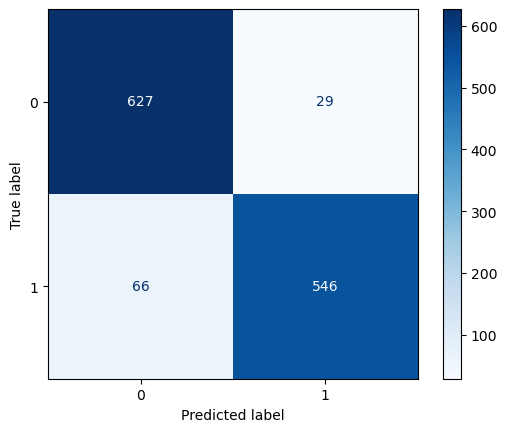

<Figure size 1200x500 with 0 Axes>

In [258]:
custom_stopwords_rationality = [
    'Logic', 'Reason', 'Analysis', 'Judgment', 'Objective', 'Critical', 'Thought', 'Rational', 'Intelligent',
    'Perception', 'Understanding', 'Insight', 'Clarity', 'Deduction', 'Cognition', 'Discernment', 'Knowledge',
    'Wisdom', 'Comprehension', 'Conception', 'Interpretation', 'Awareness', 'Reflection', 'Evaluation',
    'Perspective', 'Coherence', 'Intellectual', 'Pragmatic', 'Conceptualization', 'Inference', 'Intuition',
    'Skepticism', 'Theory', 'Synthesis', 'Discourse', 'Methodical', 'Prudence', 'Assumption', 'Hypothesis',
    'Deliberation', 'Argumentation', 'Coherence', 'Computation', 'Conjecture', 'Empiricism', 'Fact',
    'Hypothesizing', 'Logicism', 'Objectivity', 'Pragmatism', 'Precision', 'Rationalization', 'Realism',
    'Reasoning', 'Structured', 'Systematic', 'Theoretical', 'Validity', 'Verification', 'Analytical',
    'Abstraction', 'Accuracy', 'Acumen', 'Adjudication', 'Algorithm', 'Axiology', 'Cerebration', 'Cognizance',
    'Coherence', 'Collation', 'Computation', 'Consciousness', 'Consilience', 'Contemplation', 'Corollary',
    'Criterion', 'Deductivism', 'Demythologization', 'Determinism', 'Dialectics', 'Didactic', 'Disambiguation',
    'Discretion', 'Disquisition', 'Distillation', 'Duality', 'Eclecticism', 'Efficacy', 'Elucidation', 'Empiric',
    'Epistemology', 'Equanimity', 'Equivocation', 'Erudition', 'Esoteric', 'Exegesis', 'Explication', 'Exposition',
    'Expounding', 'Extensionality', 'Fallibilism', 'Falsifiability', 'Forensics', 'Formalism', 'Formulation',
    'Foundationism', 'Futurism', 'Generalization', 'Hermeneutics', 'Heuristics', 'Holism', 'Homiletics', 'Humanism',
    'Idealism', 'Illumination', 'Imperative', 'Implication', 'Indubitability', 'Inductionism', 'Informativeness',
    'Ingenuity', 'Inquisitiveness', 'Inspection', 'Intelligibility', 'Interpolation', 'Introspection', 'Irreducibility',
    'Justification', 'Legitimacy', 'Literalism', 'Logicality', 'Materialism', 'Metacognition', 'Methodology',
    'Mnemonic', 'Modality', 'Naturalism', 'Necessitarianism', 'Neurophilosophy', 'Nomothetic', 'Noncontradiction',
    'Normativity', 'Occam’s Razor', 'Ontology', 'Operationalism', 'Oppugnation', 'Ordinality', 'Organon', 'Paradigm',
    'Pedagogy', 'Phenomenology', 'Postulation', 'Postulatum', 'Praxeology', 'Predication', 'Presupposition',
    'Probity', 'Problematics', 'Process', 'Prognostication', 'Propaedeutics', 'Proposition', 'Provenance',
    'Provocation', 'Punctiliousness', 'Qualification', 'Quantification', 'Quintessence', 'Ratiocination',
    'Realpolitik', 'Recapitulation', 'Reification', 'Relevancy', 'Rigorism', 'Sapience', 'Schematization',
    'Scrutiny', 'Solecism', 'Solipsism', 'Syllogistics', 'Syncretism', 'Teleology', 'Tenable', 'Transduction',
    'Utilitarian'
]


stop_word_eval(custom_stopwords_rationality)

Removal of 185 words related to rationality, logic and synonyms yielded nothing conclusive.

#### Removing Words Related to Emotions

Additonal stop words: 137
Default stop words: 318
Total stop words: 455
train score: 0.9623125493291239
test score: 0.9266561514195584
balanced_accuracy: 0.9256635581061693
f1 score: 0.9219143576826195
sensitivity (recall): 0.8970588235294118
specificity (precision): 0.9542682926829268


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, max_features=4000,
                                 stop_words=['most', 'this', 'are', 'becoming',
                                             'must', 'take', 'last', 'were',
                                             'done', 'move', 'would', 'still',
                                             'five', 'nothing', 'thereby',
                                             'she', 'i', 'here', 'during',
                                             'meanwhile', 'wherever', 'indeed',
                                             'hundred', 'third', 'rather',
                                             'nobody', 'hasnt', 'several',
                                             'above', 'beside', ...])),
                ('logreg',
                 LogisticRegression(C=0.97, max_iter=10000, random_state=42))])

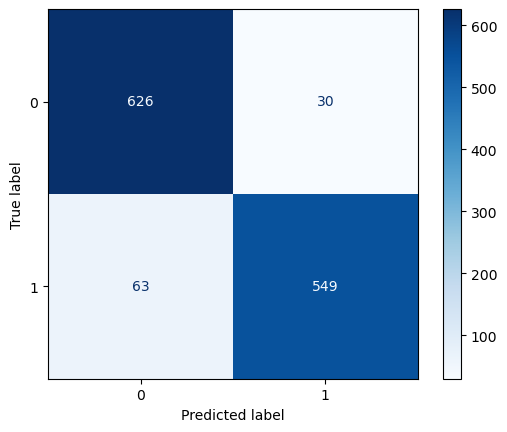

<Figure size 1200x500 with 0 Axes>

In [259]:
custom_stopwords_emotions = [
    'Admiration', 'Amazement', 'Ambivalence', 'Amusement', 'Anguish', 'Annoyance', 'Anticipation', 'Anxiety', 
    'Apprehension', 'Astonishment', 'Awe', 'Bafflement', 'Bewilderment', 'Boredom', 'Bravery', 'Calmness', 
    'Cautiousness', 'Certainty', 'Comfort', 'Confidence', 'Confusion', 'Curiosity', 'Cynicism', 'Defeat', 
    'Defensiveness', 'Delight', 'Depression', 'Despair', 'Disbelief', 'Discontent', 'Distress', 'Eagerness', 
    'Earnestness', 'Ease', 'Embarrassment', 'Enchantment', 'Encouragement', 'Endearment', 'Enthusiasm', 
    'Euphoria', 'Exasperation', 'Expectancy', 'Fascination', 'Fatigue', 'Flustered', 'Forgiveness', 'Friendliness', 
    'Fulfillment', 'Generosity', 'Gladness', 'Gleefulness', 'Gloom', 'Graciousness', 'Grimness', 'Harmony', 
    'Hatred', 'Helplessness', 'Hesitation', 'Homesickness', 'Honor', 'Horror', 'Hostility', 'Humiliation', 
    'Hunger', 'Hurt', 'Impatience', 'Inadequacy', 'Incredulity', 'Inferiority', 'Innocence', 'Insecurity', 
    'Inspiration', 'Intimidation', 'Irritation', 'Isolation', 'Jealousy', 'Jollity', 'Jubilation', 'Languor', 
    'Lassitude', 'Lethargy', 'Longing', 'Loathing', 'Loneliness', 'Lust', 'Misery', 'Mortification', 'Motivation', 
    'Neglect', 'Nervousness', 'Numbness', 'Overwhelm', 'Panic', 'Paranoia', 'Patriotism', 'Peace', 'Pity', 
    'Pleasure', 'Powerlessness', 'Preoccupation', 'Pride', 'Rapture', 'Rejection', 'Relaxation', 'Relief', 
    'Remorse', 'Resignation', 'Restlessness', 'Revulsion', 'Sadness', 'Satisfaction', 'Scorn', 'Sentimentality', 
    'Shock', 'Smugness', 'Solitude', 'Spite', 'Stress', 'Submission', 'Surprise', 'Suspense', 'Tenderness', 
    'Tension', 'Terror', 'Thankfulness', 'Tiredness', 'Tranquility', 'Unease', 'Vexation', 'Vigilance', 'Wistfulness', 
    'Wonder', 'Worry', 'Wrath', 'Yearning', 'Zeal', 'Zest'
]

stop_word_eval(custom_stopwords_emotions)

Removal of 137 words directly related to emotions yielded nothing conclusive.

## Random Forests Model - Evaluation:

**Results RandomForests with TF-IDF v1:**<br/>
Best parameters: {'rf__min_samples_split': 15, 'tfidf__max_df': 0.7, 'tfidf__max_features': 4500, 'tfidf__ngram_range': (1, 1)}<br/>
Best score: 0.913608251275248<br/>
Train score:  0.9969437652811736<br/>
Test score:  0.9047231270358306<br/>

In [274]:
# evaluating production random forests model from 03_optimal_model.ipynb

rf_best_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df = 0.7, max_features = 4500, 
                              ngram_range = (1, 1))),
    ('rf', RandomForestClassifier(min_samples_split=15, random_state=42))
])

rf_best = rf_best_pipe.fit(X_train, y_train)

train score: 0.9972375690607734
test score: 0.9124605678233438
balanced_accuracy: 0.911670054200542
f1 score: 0.9074228523769808
sensitivity (recall): 0.8888888888888888
specificity (precision): 0.9344512195121951


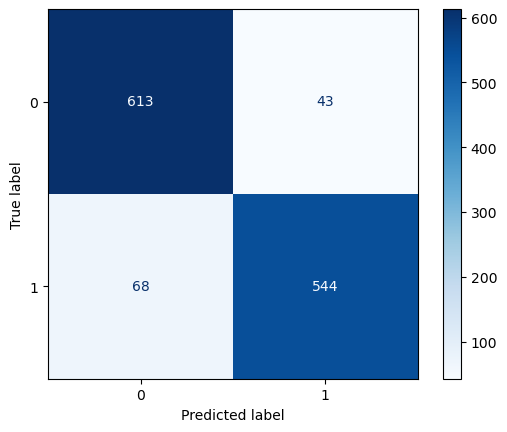

<Figure size 1200x500 with 0 Axes>

In [275]:
print('train score:', rf_best.score(X_train, y_train))
print('test score:', rf_best.score(X_test, y_test))
rf_best_preds = predict_evaluate(X_test, y_test, rf_best);

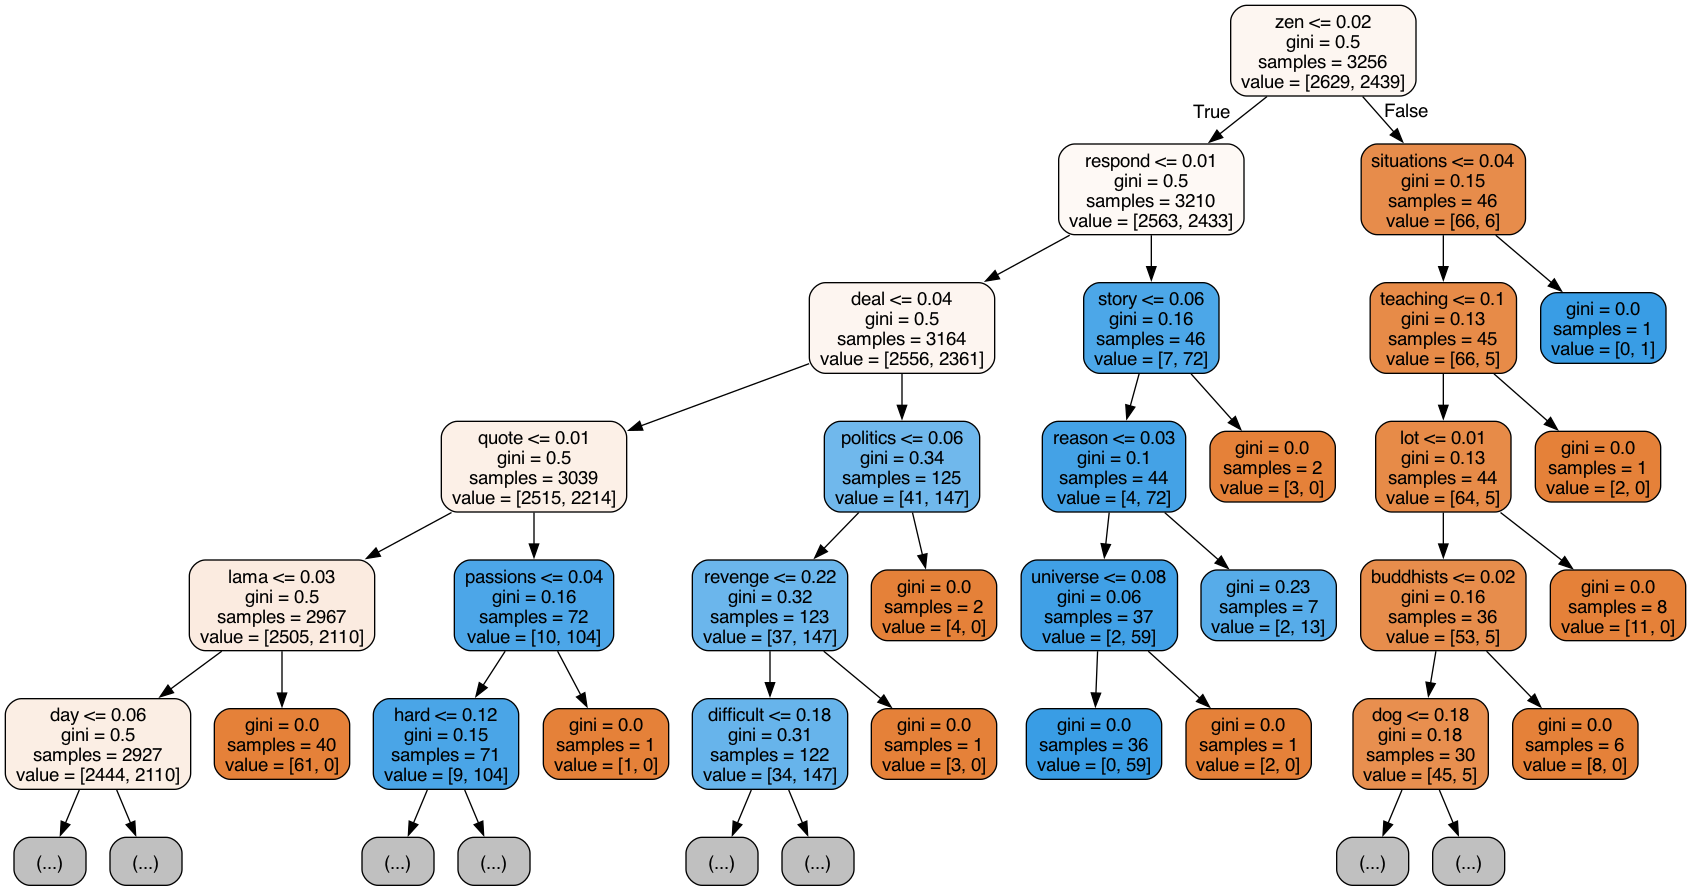

In [276]:
# source for following code: 
# https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c  

rf_estimator = rf_best.named_steps['rf']

estimator = rf_estimator.estimators_[5]

# creating exporting decision_tree as dot file
export_graphviz(estimator, out_file='./images/decision_tree.dot', 
                feature_names = rf_best.named_steps['tfidf'].get_feature_names_out(),
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=5)

# conversion to PNG
path = './images/decision_tree.dot'
s = Source.from_file(path)
s.render('./images/decision_tree', format='png', cleanup=True)

# display file
Image(filename = './images/decision_tree.png')

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['green', 'paticca', 'samuppada', 'white'] not in stop_words.
  warnings.warn(


train score: 0.994475138121547
test score: 0.7429022082018928
balanced_accuracy: 0.7427566555077316
f1 score: 0.734959349593496
sensitivity (recall): 0.738562091503268
specificity (precision): 0.7469512195121951


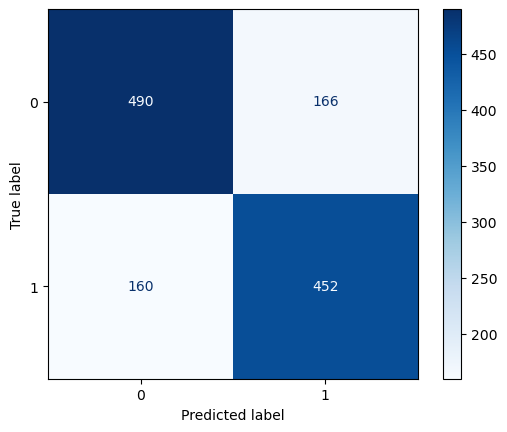

<Figure size 1200x500 with 0 Axes>

In [277]:
# restricting rf model with same list of technical terminology 

rf_best_pipe_sw = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=custom_stopwords_technical_jargon, max_df = 0.7, max_features = 4500, 
                              ngram_range = (1, 1))),
    ('rf', RandomForestClassifier(min_samples_split=15, random_state=42))
])

rf_best_sw = rf_best_pipe_sw.fit(X_train, y_train)

print('train score:', rf_best_sw.score(X_train, y_train))
print('test score:', rf_best_sw.score(X_test, y_test))
rf_best_preds = predict_evaluate(X_test, y_test, rf_best_sw)

rf_estimator_sw = rf_best_sw.named_steps['rf']

estimator_sw = rf_estimator_sw.estimators_[5]

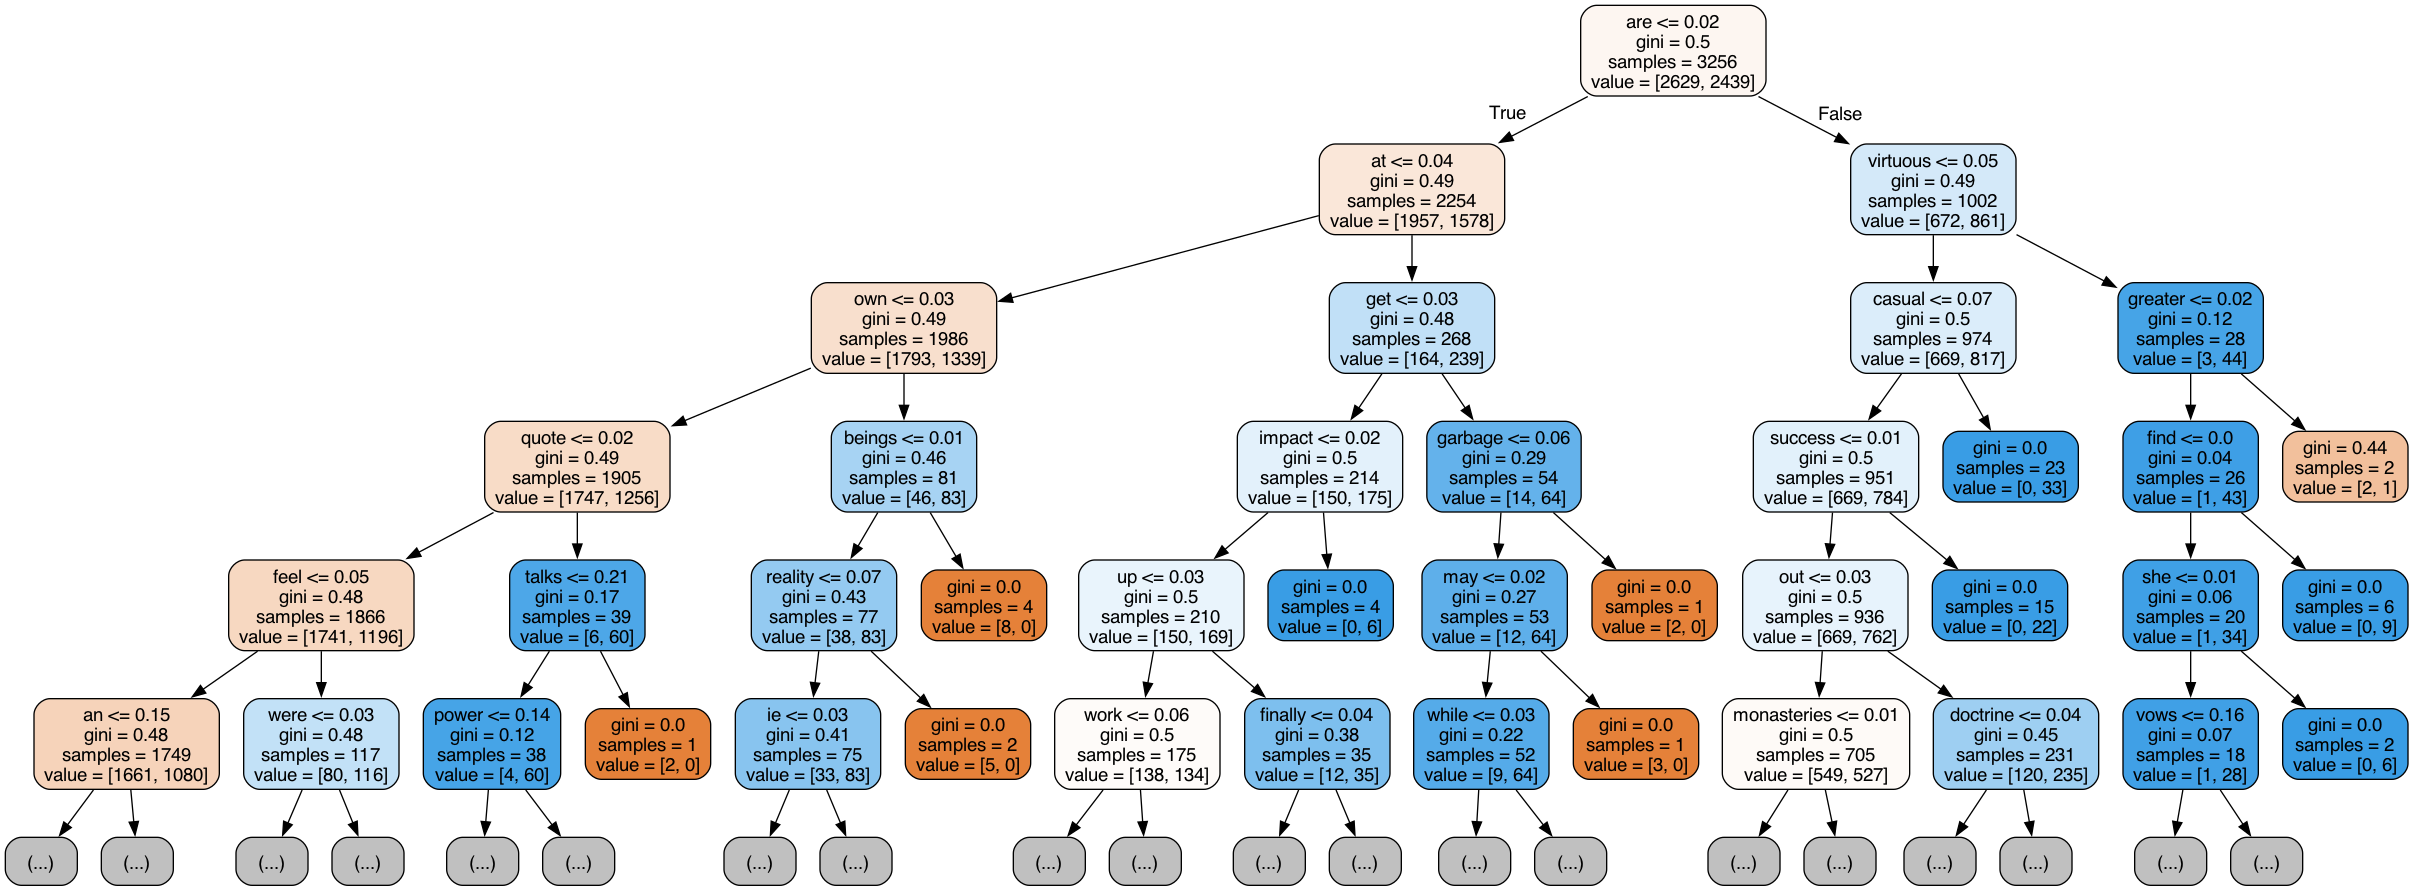

In [278]:
# creating exporting decision_tree as dot file
export_graphviz(estimator_sw, out_file='./images/decision_tree_sw.dot', 
                feature_names = rf_best_sw.named_steps['tfidf'].get_feature_names_out(),
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=5)

# conversion to PNG
path = './images/decision_tree_sw.dot'
s = Source.from_file(path)
s.render('./images/decision_tree_sw', format='png', cleanup=True)

# display file
Image(filename = './images/decision_tree_sw.png')

**Standard Stop Words - Random Forests:**<br/>
train score: 0.9968429360694554<br/>
test score: 0.9140378548895899<br/>
balanced_accuracy: 0.9130300494181411<br/>
f1 score: 0.90848026868178<br/>
sensitivity (recall): 0.8839869281045751<br/>
specificity (precision): 0.9420731707317073<br/>

**Removal of Technical Jargon - Random Forests:**<br/>
train score: 0.994869771112865<br/>
test score: 0.748422712933754<br/>
balanced_accuracy: 0.7484756097560976<br/>
f1 score: 0.742118027485853<br/>
sensitivity (recall): 0.75<br/>
specificity (precision): 0.7469512195121951<br/>

**Insights:**<br/>
- Test accuracy and balance accuracy fell around 25% with the removal of technical Jargon. <br/>
- False positives (r/buddhism post classified incorrectly as r/stoicism)  38 to 171. <br/>
- False negatives (r/stoicism post classified incorrectly as r/buddhism) went from 71 to 158.<br/>
- Suggests that the random forests model relied fairly heavily on technical Jargon to classify buddhism posts relative to stoicism posts. But relied on both to a significant extent. <br/>
- The model performed worse than the logistic regression model with these terms removed. <br/>

## Comparing the Models

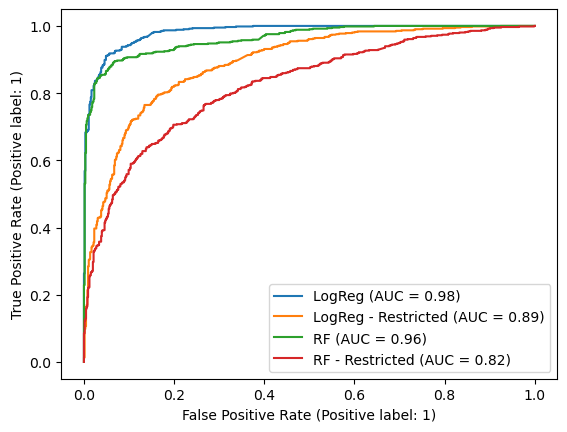

In [279]:
ax = plt.gca()
# use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(logreg_best, X_test, y_test, ax=ax, name='LogReg')
RocCurveDisplay.from_estimator(sw_tj_pipe, X_test, y_test, ax=ax, name='LogReg - Restricted')
RocCurveDisplay.from_estimator(rf_best, X_test, y_test, ax=ax, name='RF')
RocCurveDisplay.from_estimator(rf_best_sw, X_test, y_test, ax=ax, name='RF - Restricted')

# necessary to label the baseline
plt.legend();

**Comparing Best Models Insights:**
- Random Forest classifier showed decreased balanced accuracy compared to Logistic Regression.<br/>
- Random Forest had more balanced recall and precision however, Random Forest was underperforming the Logistic Regression in identifying the positive class (r/stoicism) as can be seen from the plotted ROC curve. <br/>
- Random Forest exhibited higher variance and bias on the test dataset.<br/>
- Random Forest showed a lower F1 score compared to logistic regression.<br/>

**Comparing Restricted Models:**
- Random Forest classifier showed decreased balanced accuracy compared to Logistic Regression with technical jargon removed.<br/>
- A decrease in AUC of 0.14 (from 0.96 to 0.82) compared to Logistic Regression decrease of 0.9 (from 0.98 to 0.89).<br/>

# Key Findings and Conclusion:
- **High Accuracy**: The model achieved over 90% accuracy on unseen data, demonstrating its robustness and predictive power.
- **Extreme Coefficient Technical Terms:** 
    - For example, A post containing the word 'epicutus' increased log odds of the post being from r/stoicism by 4.1. 
    - A post containing the word 'karma' decreased log odds of the post being from r/stoicism by 3.4. 
- **Technical Jargon Defined**: The model's performance was significantly influenced by technical jargon. This jargon includes names of philosophers, philosophical writings, and words in Greek, Latin, Pali, or Sanskrit.
- **Decrease in Accuracy**: When technical jargon was removed, both test accuracy and balanced accuracy dropped by 11%.
- **Increase in Errors**: The removal of technical jargon resulted in a 126% increase in both false negatives and false positives, indicating the model's reliance on this jargon for classification.
- **Above Baseline Performance**: Even with reduced accuracy (81%), the model performed 30% above the baseline, effectively classifying submissions. Which suggests despite having very similar foundational ideas, being translated to english and being re-intrepretted over centuries, the philosophies appear to have remarkably distinct vocabularies:
    1. **Stoicism vs Buddhism**: 
        - Stoicism subreddit often involves terms like 'virtues' and 'virtuous', whereas Buddhism focuses on 'enlightenment'. A submission containing the word 'virtue' increases log odds of a post being from r/stoicism by 1.7, whereas a submission containing the word 'enlightenment' decreases log odds of a post being from r/stoicism by 2.1.
        - Stoics frequently mention 'care', while Buddhists emphasize 'compassion' - these were distribguidhing coefficients. 
    2. **Vocabulary Differences in bottom/top 50 coefficients**:
        - Stoicism subreddit had more verbs such as: 'control', 'live', 'react', 'work', 'gonna', 'respond', 'act', 'deal', 'think', 'going', 'handle', 'stop', 'advice'.
        - Buddhism subreddit verbs were: 'thank', 'practice', 'suffering', 'teaching', 'painting', 'killing'.
    3. **Emotional and Mental Statesin bottom/top 50 coefficients**:
        - Buddhism subreddit terms related to mental states and emotions appear more prevalent: 'suffering', 'peace', 'compassion', 'emptiness', 'mindful', 'enlightenment', 'enlightened', 'beautiful'.
        - Stoicism subreddit: 'emotions', 'emotionally', 'emotion', 'react', 'strength'.
